# 损失函数

## 一、损失函数类型

### 1.交叉熵-cross_entropy
* **预测分布越接近真实的分布，交叉熵越小，当预测分布等于真实分布时，交叉熵最小，此时交叉熵的值等同于熵。所以，交叉熵提供了一种衡量两个分布之间差异大小的方式，常用来作为神经网络的损失函数。当预测分布跟真实分布（人工标注结果）相差很大时，交叉熵就大；当随着训练的进行预测分布越来越接近真实分布时，交叉熵就逐渐减小。**
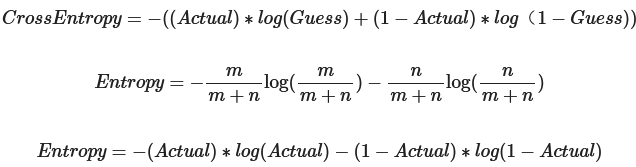
* **交叉熵梯度下降公式矩阵表达**
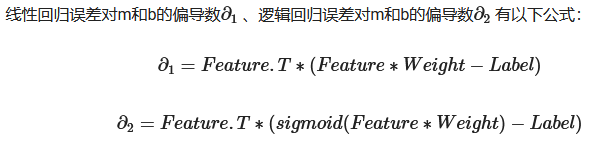

### 2.IOU(Intersection over Union)
* **IoU就是我们所说的交并比，是目标检测中最常用的指标，在anchor-based的方法中，它的作用不仅用来确定正样本和负样本，还可以用来评价输出框（predict box）和ground-truth的距离。**
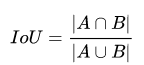
* **优点：（1）它可以反映预测检测框与真实检测框的检测效果。<br>
   （2）尺度不变性，也就是对尺度不敏感（scale invariant）， 在regression任务中，判断predict box和gt的距离最直接的指标就是IoU。(满足非负性；同一性；对称性；三角不等性)**<br>
* 举例：
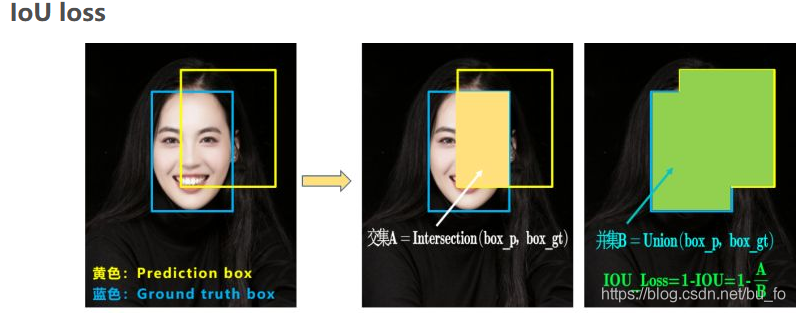

### 3.均方误差（mean_squared）
* **MSE表示了预测值与目标值之间差值的平方和然后求平均**
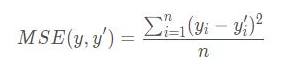

## 二、函数解析

* 1.logits：未归一化的概率，即各个特征的加权之和。logits经过sigmoid或softmax函数变为归一化的概率值。<br>
    logits=log(p/(1-p)) ；<br>
    p=1/(1+e^(-logits))；<br><br>
* 2.tf.reshape(tensor,shape,name=None):函数的作用是将tensor变换为参数shape形式，其中的shape为一个列表形式，特殊的是列表可以实现逆序的遍历，即list(-1).-1所代表的含义是我们不用亲自去指定这一维的大小，函数会自动进行计算，但是列表中只能存在一个-1。（如果存在多个-1，就是一个存在多解的方程）。<br><br> 
* 3.any() 函数用于判断给定的可迭代参数 iterable 是否全部为 False，则返回 False，如果有一个为 True，则返回 True。
   元素除了是 0、空、FALSE 外都算 TRUE。**<br><br> 
* 4.tf.constant(value,dtype=None,shape=None,name='Const',verify_shape=False):创建常量。**<br><br>
* 5.tf.multiply(x,y,name=None)：相同位置的元素相乘。**<br><br>
* 6.tf.reduce_sum(input_tensor, axis=None, keepdims=None,name=None)：在给定维度上求和。**<br><br>
* 7.tf.nn.softmax(logits,axis=None,name=None,dim=None)：<br>
  作用：softmax函数的作用就是归一化。<br>
  输入: 全连接层（往往是模型的最后一层）的值，一般代码中叫做logits<br>
  输出: 归一化的值，含义是属于该位置的概率，一般代码叫做probs。例如输入[0.4,0.1,0.2,0.3],那么这个样本最可能属于第0个位置，也就是第0类。这是由于logits的维度大小就设定的是任务的类别，所以第0个位置就代表第0类。softmax函数的输出不改变维度的大小。<br>
  用途：如果做单分类问题，那么输出的值就取top1(最大，argmax)；如果做多(N)分类问题，那么输出的值就取topN**<br><br>
* 8.tf.nn.softmax_cross_entropy_with_logits_v2(_sentinel=None,labels=None,logits=None,dim=-1,name=None):<br>
  sentinel：一个内部参数，具体作用还未可知;<br>
  labels：真实标签，注意是一个onehot向量，且长度跟logits一样长，长度为类别数;<br>
  logits：模型最后一层的输出，注意不要过softmax函数，维度为[batch_size,numclass];<br>
  dim: 按照哪一个维度去求的，默认-1也就是最后一维，也就是按照类别数来求的，如果类别数在第一维的话，这里必须要改成0.<br>
  tf.nn.softmax_cross_entropy_with_logits:反向传播时，只会反向传播logits，label不会反向传播;<br>
  v2新版：反向传播时，logits和labels都会反向传播.**<br><br>
* 9.tf.reduce_mean**<br><br>
* 10.tf.losses.mean_squared_error：均方根误差（MSE） —— 回归问题中最常用的损失函数。<br>
  优点是便于梯度下降，误差大时下降快，误差小时下降慢，有利于函数收敛。<br>
  缺点是受明显偏离正常范围的离群样本的影响较大。**<br><br>

In [ ]:
#损失函数
  def add_loss_op(self):
    if self.loss_type == "cross_entropy":
      with tf.compat.v1.variable_scope("cross_entropy"):
        flat_logits = tf.reshape(self.logits, [-1, self.n_class], name="logits")
        flat_labels = tf.reshape(self.Y, [-1, self.n_class], name="labels")
        if (np.array(self.class_weights) != 1).any():
          class_weights = tf.constant(np.array(self.class_weights, dtype=np.float32), name="class_weights")
          weight_map = tf.multiply(flat_labels, class_weights)
          weight_map = tf.reduce_sum(input_tensor=weight_map, axis=1)
          loss_map = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                     labels=flat_labels)
#                     loss_map = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits,
#                                                                       labels=flat_labels)
          weighted_loss = tf.multiply(loss_map, weight_map)
          loss = tf.reduce_mean(input_tensor=weighted_loss)
        else:
          loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                         labels=flat_labels))
#                     loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits,
#                                                                                   labels=flat_labels))
    elif self.loss_type == "IOU":
      with tf.compat.v1.variable_scope("IOU"):
        eps = 1e-7
        loss = 0
        for i in range(1, self.n_class): 
          intersection = eps + tf.reduce_sum(input_tensor=self.preds[:,:,:,i] * self.Y[:,:,:,i], axis=[1,2])
          union = eps + tf.reduce_sum(input_tensor=self.preds[:,:,:,i], axis=[1,2]) + tf.reduce_sum(input_tensor=self.Y[:,:,:,i], axis=[1,2]) 
          loss += 1 - tf.reduce_mean(input_tensor=intersection / union)
    elif self.loss_type == "mean_squared":
      with tf.compat.v1.variable_scope("mean_squared"):
        flat_logits = tf.reshape(self.logits, [-1, self.n_class], name="logits")
        flat_labels = tf.reshape(self.Y, [-1, self.n_class], name="labels")
        with tf.compat.v1.variable_scope("mean_squared"):
          loss = tf.compat.v1.losses.mean_squared_error(labels=flat_labels, predictions=flat_logits) 
    else:
      raise ValueError("Unknown loss function: " % self.loss_type)

    tmp = tf.compat.v1.summary.scalar("train_loss", loss)
    self.summary_train.append(tmp)
    tmp = tf.compat.v1.summary.scalar("valid_loss", loss)
    self.summary_valid.append(tmp)

    if self.weight_decay > 0:
      with tf.compat.v1.name_scope('weight_loss'):
        tmp = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES)
        weight_loss = tf.add_n(tmp, name="weight_loss")
      self.loss = loss + weight_loss 
    else:
      self.loss = loss 